In [1]:
# Importing all the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=2.0, style='whitegrid', color_codes=True)

# Sentiment Libraries
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import torch

import ast
from datetime import datetime
from tqdm import tqdm
import time

pd.set_option('max_colwidth', 200)
pd.set_option('display.max_rows',100)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/daniel/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_csv('VADER_Sentiment_result.csv')
data.head(5)

,content,Text_new,Datecreated,Month,VADER_Scores,VADER_Polarity,VADER_Sentiment
0,Code-generating #AI can introduce #security #vulnerabilities \nhttps://t.co/tBoOQkK4LD\n\n#cryptocurrencies #MachineLearning #AI #Python #DeepLearning #100DaysOfCode #fintech #nocode #bitcoin #cyb...,code generate ai introduce security vulnerability machinelearning ai-python-deeplearning daysofcode-fintech-nocode-bitcoin cybersecurity-cybersecurite-insurtech chatgpt,2022-12-29,12,"{'neg': 0.143, 'neu': 0.677, 'pos': 0.18, 'compound': 0.128}",0.1280,Neutral
1,Advanced prompt engineering also needs some kind of #security #ChatGPT @SGgrc \nhttps://t.co/euF66Y2KXt,advanced prompt engineering also need kind security chatgpt,2022-12-29,12,"{'neg': 0.0, 'neu': 0.391, 'pos': 0.609, 'compound': 0.7783}",0.7783,Positive
2,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/EYOMaiWkn5.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding...,chatgpt big deal digital security ai ainews application bug chatbot chatbots code cod composition computer customerservice cybersecurity da,2022-12-29,12,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'compound': 0.34}",0.3400,Positive
3,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/1mLxQxpvAS.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding...,chatgpt big deal digital security ai ainews application bug chatbot chatbots code cod composition computer customerservice cybersecurity da,2022-12-29,12,"{'neg': 0.0, 'neu': 0.876, 'pos': 0.124, 'compound': 0.34}",0.3400,Positive
4,I’ve been down the chat GPT rabbit hole.. and I’m fucking scared I’m not making it out of college with any job security,chat-gpt rabbit hole fuck scar make college job security,2022-12-28,12,"{'neg': 0.271, 'neu': 0.543, 'pos': 0.186, 'compound': -0.2732}",-0.2732,Negative


In [23]:
len(data)

38537

In [6]:
from datetime import datetime
data['Date'] = pd.to_datetime(data['date'])

# Set the start date as the first day of the first week
start_date = pd.to_datetime('2022-11-30')

# Create a date range from the first day of the first week to January 31, 2023
dates = pd.date_range(start=start_date, end='2023-05-31')

#create a dictionary to store date-week
date_week = {}
for date in dates:
    week = date.isocalendar().week - start_date.isocalendar().week + 1
    if week < 0:
        week += 52
    date_week[date] = week

In [15]:
#only save the columns that we need for sentiment analysis
df_sample = data[['content', 'Text_new', 'Datecreated', 'Month','Date']].copy()
# drop date column
df_sample.head(5)

,content,Text_new,Datecreated,Month,Date
0,Code-generating #AI can introduce #security #vulnerabilities \nhttps://t.co/tBoOQkK4LD\n\n#cryptocurrencies #MachineLearning #AI #Python #DeepLearning #100DaysOfCode #fintech #nocode #bitcoin #cyb...,code generate ai introduce security vulnerability machinelearning ai-python-deeplearning daysofcode-fintech-nocode-bitcoin cybersecurity-cybersecurite-insurtech chatgpt,2022-12-29,12,2022-12-29 18:00:31+00:00
1,Advanced prompt engineering also needs some kind of #security #ChatGPT @SGgrc \nhttps://t.co/euF66Y2KXt,advanced prompt engineering also need kind security chatgpt,2022-12-29,12,2022-12-29 13:15:14+00:00
2,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/EYOMaiWkn5.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding...,chatgpt big deal digital security ai ainews application bug chatbot chatbots code cod composition computer customerservice cybersecurity da,2022-12-29,12,2022-12-29 06:47:28+00:00
3,#ChatGPT is a big #Deal and here’s why…\n\n-- Digital Security | The ...: https://t.co/1mLxQxpvAS.\n\n#2023 #Ai #AiNews #Applications #ArtificialIntelligence #Bugs #Chatbot #Chatbots #Code #Coding...,chatgpt big deal digital security ai ainews application bug chatbot chatbots code cod composition computer customerservice cybersecurity da,2022-12-29,12,2022-12-29 06:47:10+00:00
4,I’ve been down the chat GPT rabbit hole.. and I’m fucking scared I’m not making it out of college with any job security,chat-gpt rabbit hole fuck scar make college job security,2022-12-28,12,2022-12-28 20:13:28+00:00


In [17]:
%%time
#Initialize the vader sentiment analyser
vader_model = SentimentIntensityAnalyzer()
#apply VADER model to the dataset
df_sample['VADER_Scores'] = df_sample['Text_new'].apply(lambda x: vader_model.polarity_scores(x))


CPU times: user 5.21 s, sys: 1.03 ms, total: 5.21 s
Wall time: 5.21 s


In [18]:
#VADER returned the scores as a dictionary
#get the compound score as the polarity score
df_sample['VADER_Polarity'] = df_sample['VADER_Scores'].apply(lambda x: x['compound'])

#Assign labels for each tweet, depending on the polarity.
#Sentiment labels are assigned according to the polarity score: 
'''
-1 to -0.25 => negative; 
-0.25 and 0.25 => neutral; 
0.25 to 1 => positive;
'''
df_sample['VADER_Sentiment'] = pd.cut(df_sample['VADER_Polarity'],
                                bins = [-1, -0.25, 0.25, 1],
                                labels=['Negative', 'Neutral', 'Positive'])

In [11]:
df_sample.to_csv('VADER_Sentiment_result.csv', index=False)

Text(0.5, 1.0, 'Sentiment of Tweets about \nChatGPT Security by VADER')

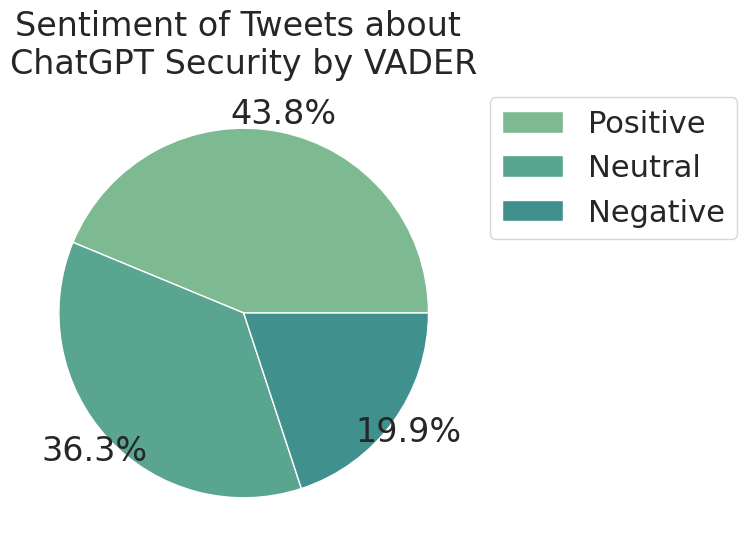

In [20]:
sns.set_palette('crest')
fig,ax=plt.subplots(1,1,figsize=(10,6))
plt.subplot(1,1,1)
pie_1 = df_sample['VADER_Sentiment'].value_counts()
plt.pie(pie_1, autopct="%.1f%%", pctdistance=1.1)
plt.legend(labels = pie_1.index, 
          bbox_to_anchor=[1,1])
plt.title('Sentiment of Tweets about \nChatGPT Security by VADER')

### Roberta Model

In [3]:
#load the model and tokenizer

model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_path)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [4]:
 #function that takes text and model to calculate the probability of each sentiment
def sentiment_analyzer(tweet,model):
    #return the output of PyTorch tensors
    encoded_tweet = tokenizer(tweet, return_tensors='pt', max_length=512, truncation=True, padding='max_length')   
    
    #calculate the sentiment
    output = model(**encoded_tweet)           
    
    #returning a NumPy array containing the embeddings of scores
    scores = output[0][0].detach().numpy()
    #normalize the scores to probability
    probability = np.round(softmax(scores),3)

    #calculate the polarity by multiply each probability to its weight(Negative:-1, Neutral:0, Positive:1)
    #define weight vector
    polarity_weights = torch.tensor([-1, 0, 1])
    
    #construct the tensor of probability
    probability = torch.tensor(probability)
    
    #calculate the polartiy score
    polarity = polarity_weights*probability
    
    # sum the weighted probabilities along the last dimension
    polarity = polarity.sum(dim=-1)
    
    #Scale polarity score to range [-1, 1]
    polarity_scaled = torch.nn.Tanh()(polarity)
    
    return round(polarity_scaled.item(),4) 

In [9]:
#as the roBERTa running will be quite long, will split the dataframe into chunks of 20k tweets each
n = 500  #chunk row size
list_df_2=[data[i:i+n].copy() for i in range(0,data.shape[0],n)]



In [10]:
len(list_df_2)

78

In [ ]:
# the dataframe has been splitted into 41 groups with 20000 tweets and an extra one with the remainder (12924 tweets)
# will run the analysis over each one separately and then store in a csv file in case it crahses instead of redoing it again.
i = 0
for df in list_df_2[0:]:
    i = i + 1
    df['ROBERTA_Polarity'] = tqdm(data['Text_new'].apply(lambda x: sentiment_analyzer(x, roberta_model)))
    df.to_csv(f'roberta_model/chunk_{i}.csv',index=False)
    print(f"Chunk {i} saved successfully.")

In [ ]:
# import glob   
# #list all cvs file into a list
# cvs_list = glob.glob('roberta_temp/*.{}'.format(csv))

# #concat all csv files into one dataframe
# df_sentiment = pd.concat([pd.read_csv(file) for file in cvs_list])

In [37]:
df_sentiment = data.copy()

In [50]:
df_sentiment['ROBERTA_Polarity'] = df_sentiment['Text_new'].apply(lambda x: sentiment_analyzer(x,roberta_model))

IndexError: index out of range in self

In [ ]:
df_sentiment['ROBERTA_Sentiment'] = pd.cut(df_sentiment['ROBERTA_Polarity'],
                                          bins = [-1, -0.25, 0.25, 1],
                                          labels = ['Negative', 'Neutral', 'Positive'])

In [ ]:
df_sentiment.to_csv('Twitter_Sentiment_ROBERTA.csv', index=False)

In [ ]:
df_sentiment = pd.read_csv('Twitter_Sentiment_ROBERTA.csv')

In [ ]:
#Random samples that VADER and ROBERTA models gave different sentiment output
df_sentiment[df_sentiment['ROBERTA_Sentiment']!= df_sentiment['VADER_Sentiment']].sample(100)

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.kdeplot(df_sentiment['VADER_Polarity'],shade=True, legend='Vader', alpha=0.8)
ax = sns.kdeplot(df_sentiment['ROBERTA_Polarity'], shade=True, legend='roBERTa', alpha=0.5)
ax.set_xlabel('Polarity of Tweets')
ax.set_title('Distribution of the Polarity of Tweets via VADER vs roberta')
plt.legend(['Vader','roBERTa'])
plt.show()

In [ ]:
# Sentiment of each topic

topic_sen = df_sentiment.groupby('Topic_Name')['ROBERTA_Sentiment'].value_counts().unstack().reset_index()
#sort by the popularity of the topics (total count)
topic_sen['Total']=topic_sen['Negative']+topic_sen['Neutral']+topic_sen['Positive']
topic_sen = topic_sen.sort_values('Total')
topic_sen=topic_sen.drop(columns='Total')
topic_sen = topic_sen.set_index('Topic_Name')

ax=topic_sen.plot(kind='barh',stacked='True', color=['#ece7f2', '#a6bddb', '#2b8cbe'], figsize=(15,8))
#get the percentage of each sentiment in specific topic
percentages = topic_sen.div(topic_sen.sum(axis=1), axis=0)
percentages = percentages.reset_index().melt('Topic_Name', var_name='Sentiment', value_name='Percentage')
#label the percentage of each sentiment
for i, patch in enumerate(ax.patches):
    ax.text(patch.get_x()+patch.get_width()/2, 
            patch.get_y()+0.25, 
            f'{round(percentages.loc[i,"Percentage"]*100,2)}%', 
            ha='center', va='center', 
            color='black', fontsize=11)
ax.set_xlabel('Count of Tweets')
ax.set_ylabel('Topics')
plt.show()